# Spectrum calculation

This section focus on the calculation of XPS, XAS, XES, and RIXS, with focus on considering these spectroscopies with ADC and (TD)DFT. For a more general overview of the large number of methods available for considering these properties, see, *e.g.*, {cite}`xrayrev2018`.

*Loading modules and functions:*

In [6]:
# standard Python modules and functions
from scipy.interpolate import interp1d
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import copy

# QC software suites and functionalities
from pyscf import gto, scf, mp, cc
import veloxchem as vlx
import gator
import adcc
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection

# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI
comm = MPI.COMM_WORLD

# au to eV conversion factor
au2ev = 27.211386

(sec:xray_calc_xps)=
## X-ray photoemission spectroscopy

In XPS the photoemission of electrons is measured, yielding information on core-electron binding energies. Here we focus on the calculation of ionization potentials (IP:s), from which the isotropic photoemission spectrum is formed by giving each IP the same intensity and then broadening with an appropriate convolution function. It is possible to go beyond such a simple approach using Dyson orbitals, but it typically does not make much of a difference {cite}`ccsdDyson2019`. 

### IP:s from Koopmans' theorem

A simple model for calculating ionization potentials and electron affinities is from Koopmans' theorem, where they are estimated from the MO energies. For water, we obtain a 1s IP of:

In [4]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Create veloxchem mol and basis objects
mol_vlx = vlx.Molecule.read_str(water_xyz) 
bas_vlx = vlx.MolecularBasis.read(mol_vlx,'6-31G') 

# Perform SCF calculation
scf_gs = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_gs.compute(mol_vlx, bas_vlx)

# Extract orbital energies
orbital_energies = scf_gs.scf_tensors['E']
print('1s IP from the Koopmans theorem:',np.around(au2ev*orbital_energies[0],2))

1s IP from the Koopmans theorem: -559.5


This can be compared to the experimental value, which is 539.9 eV. The overestimation of almost 20 eV is due to lack of [relaxation](sec:xray_topics_relax), which results from the reorganization of the valence electrons in response to a reduction in screening of the nuclei. By comparison, in valence spectroscopies the change in shielding is significantly smaller, yielding a far smaller error due to the lack of relaxation for, e.g., calculation of HOMO IP:s or LUMO EA:s.

An approach for including relaxation effects IP calculations is to instead use the $\Delta\textrm{SCF}$ approach, in which the difference in total energy between the neutral and a core-hole system yields estimates of core-electron binding energies.


### The maximum overlap method

In order to converge a core-hole state, an approach which avoid the convergence to a lower-energy valence-hole state is needed. This can be done using several approaches, but the focus here will be on the maximum overlap method (MOM), with which a SCF optimization with the constraint of maximizing the overlap to some initial guess {cite}`mom1971, maxover2008`. The guess is typically taken as the converged wave function of the neutral (no core-hole) system, and new occupied orbitals at each iteration is taken such that they overlap most with the span of old occupied orbitals. Defining the overlap matrix as

\begin{equation}
\textbf{O} = 
\left( \textbf{C}^{\textrm{old}} \right)^{\dagger} \textbf{SC}^{\textrm{new}},
\end{equation}

with $O_{ij}$ being the overlap between the $i$:th old and $j$:th new orbital, and $\textbf{C}$ and $\textbf{S}$ are the MO coefficient matrices and basis function overlap matrix, respectively. The projections of $j$:th new orbital onto the old space is then

\begin{equation}
p_j = \sum_i^n O_{ij} = 
\sum_a^N (
\sum_b^N (
\sum_i^n C_{ib}^{old} )
S_{bc} )
C_{cj}^{old}.
\end{equation}

The occupied orbitals are then selected by largest $p_j$ values.

With this, a converged core-hole wave function is obtained with the following scheme:

1. Calculate the wave-function of the original system (*e.g.* no core-hole).

2. Use above wave-function as a starting guess for a new wave function optimization, removing an electron from desired orbital (and potentially occupying some other virtual orbital).

3. Optimizing this state using the MOM restriction.

This can then converge many unstable states, including core-ionized states and certain core-excited states. Some care should observed, though:

- If excited states are considered, check that the final state is reasonable close to what is investigated.

- Delocalized core orbitals need to be localized, for example by employing ECP:s.

- If post-HF methods are used, the ground state calculation can attempt to (partially) fill the core-hole, leading to a corrupt wave function which represents some intermediate between a core-hole/valence-hole state.

```{note}
We currently use `pyscf` for the calculations involving explicit core-holes, as `veloxchem` presently lacks MOM.
```

### IP:s from $\Delta\textrm{SCF}$

The IP of water using $\Delta\textrm{SCF}$ is then computed as:

In [25]:
# Create pyscf mol object
mol       = gto.Mole()
mol.atom  = water_xyz
mol.basis = '6-31G'
mol.build()

# Perform unrestricted SCF calculation
scf_gs = scf.UHF(mol)
scf_gs.kernel()

# Copy molecular orbitals
mo0  = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)

# Create 1s core-hole by setting alpha_0 population to zero
occ0[0][0] = 0.0
    
# Perform unrestricted SCF calculation with MOM constraint
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# IP from energy difference
print('Ionization potential:',np.around(au2ev*(scf_ion.energy_tot() - scf_gs.energy_tot()),2),'eV')

converged SCF energy = -75.9838703827193  <S^2> = 6.3353767e-12  2S+1 = 1
converged SCF energy = -56.0754789470864  <S^2> = 0.76257805  2S+1 = 2.0125387
Ionization potential: 541.73 eV


This estimate is within 2 eV from experiment, and we can include electron correlation using MP2:

{\bf Maybe include:} comparing MOM and IMOM (thanks to Anna Kristina and Josefine):

In [12]:
def mom_method(mf, mocoeffs, occnum):
    '''Use initial maximum overlap method to determine occupation number for each orbital in every
    iteration. It can be applied to unrestricted as well as restricted open-shell systems.'''
    
    # Copy initial MO coefficients for occupied orbitals
    
    if (isinstance(mf, dft.rks.RKS) or isinstance(mf, scf.hf.RHF)):
        coef_occ_a = mocoeffs[:, occnum>0]
    elif (isinstance(mf, dft.uks.UKS) or isinstance(mf, scf.uhf.UHF)):
        coef_occ_a = mocoeffs[0][:, occnum[0]>0]
        coef_occ_b = mocoeffs[1][:, occnum[1]>0]
        
    # Write new get_occ routine for DFT kernel
    
    def get_occ(mo_energy=None, mo_coeff=None):
        
        # Get new MO energy
        if mo_energy is None: mo_energy = mf.mo_energy
        print(mf.e_tot)
            
        # Get new MO coefficients
        if mo_coeff is None: mo_coeff = mf.mo_coeff
        
        if (isinstance(mf, dft.rks.RKS) or isinstance(mf, scf.hf.RHF)):   
            mo_occ = np.zeros_like(occnum)
            nocc_a = int(np.sum(occnum)/2) # number of occupied orbitals
            
            # Construct s_a = MO_coeff(initial)*S*MO_coeff(new)
            SC = np.matmul(mf.get_ovlp().T,mo_coeff)
            s_a = np.matmul(coef_occ_a.T, SC)
            
            # Get indices for orbitals with largest p = sum_i s_a(ij)s_a(ij)
            idx_a = np.argsort(np.einsum('ij,ij->j', s_a, s_a))[::-1]
            
            # Set occupation for selected MOs
            mo_occ[idx_a[:nocc_a]] = 2.
            
        elif (isinstance(mf, dft.uks.UKS) or isinstance(mf, scf.uhf.UHF)):
            mo_occ = np.zeros_like(occnum)
            nocc_a = int(np.sum(occnum[0])) # number of occupied alpha orbitals
            nocc_b = int(np.sum(occnum[1])) # number of occupied beta orbitals
            
            # Construct s_a = MO_coeff(initial)*S*MO_coeff(new)
            SC_a=np.matmul(mf.get_ovlp().T,mo_coeff[0])
            s_a = np.matmul(coef_occ_a.T, SC_a)
            # Likewise for s_b
            SC_b = np.matmul(mf.get_ovlp().T,mo_coeff[1])
            s_b = np.matmul(coef_occ_b.T, SC_b)
            
            # Get indices for orbitals with largest p_a = sum_i s_a(ij)s_a(ij)
            idx_a = np.argsort(np.einsum('ij,ij->j', s_a, s_a))[::-1]
            # Likewise for p_b
            idx_b = np.argsort(np.einsum('ij,ij->j', s_b, s_b))[::-1]
            
            # Set occupation for selected MOs
            mo_occ[0][idx_a[:nocc_a]] = 1.
            mo_occ[1][idx_b[:nocc_b]] = 1.

        return mo_occ
    
    # Redefine get_occ for DFT kernel as new function
    mf.get_occ = get_occ
    
    return mf

In [11]:

from pyscf import dft

# Define system
mol = gto.Mole()
mol.atom  = water_xyz
mol.basis = '6-31G'
mol.build()

core = 0 # index of core orbital

# Define unrestricted KS-DFT object
dft_gs = scf.UHF(mol)# HF example
dft_gs.kernel()

# Copy molecular orbital coefficients and occupation numbers
mo0  = copy.deepcopy(dft_gs.mo_coeff)
occ0 = copy.deepcopy(dft_gs.mo_occ)

# Create 1s core-hole by setting alpha population to zero
occ0[0][core] = 0.0

# Define unrestricted KS-DFT object for ionized species
dft_ion = scf.UHF(mol) #HF example
# invoke IMOM 
mom_method(dft_ion, mo0, occ0)

dft_ion.kernel()

# IP from energy difference
print('Ionization potential:',np.around(au2ev*(dft_ion.energy_tot() - dft_gs.energy_tot()),2),'eV')

converged SCF energy = -75.9838703827192  <S^2> = 6.3362648e-12  2S+1 = 1
0
0
0
0
0
0
0
0
0
0
0
converged SCF energy = -56.0754789470864  <S^2> = 0.76257805  2S+1 = 2.0125387
Ionization potential: 541.73 eV


In [26]:
# Run MP2 on neutral and core-hole wave functions
mp_res = mp.MP2(scf_gs).run()
mp_ion = mp.MP2(scf_ion).run()

# IP from energy difference
print('Ionization potential:',np.around(au2ev*(mp_ion.e_tot - mp_res.e_tot),2),'eV')

E(UMP2) = -76.113048395549  E_corr = -0.129178012829707
E(UMP2) = -56.1523709631034  E_corr = -0.0768920160169648
Ionization potential: 543.16 eV


Alternatively, we can consider this with KS-DFT:

In [31]:
# Perform unrestricted SCF calculation with a B3LYP
scf_gs    = scf.UKS(mol)
scf_gs.xc = 'b3lyp'
scf_gs.kernel()

# Copy molecular orbitals
mo0  = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)

# Create 1s core-hole by setting alpha_0 population to zero
occ0[0][0] = 0.0
    
# Perform unrestricted SCF calculation with MOM constraint
scf_ion    = scf.UKS(mol)
scf_ion.xc = 'b3lyp'
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# IP from energy difference
print('Ionization potential:',np.around(au2ev*(scf_ion.energy_tot() - scf_gs.energy_tot()),2),'eV')

converged SCF energy = -596.743597161621  <S^2> = 1.7813306e-10  2S+1 = 1
converged SCF energy = -571.093020311385  <S^2> = 0.75045622  2S+1 = 2.0004562
Ionization potential: 697.99 eV


MP2 and DFT currently brings us *away* from experiment when comparing to HF, but we note that the basis set is small and ill-suited for core properties. Using a cc-pCVTZ basis we obtain:
- HF: 538.93 eV
- MP2: 540.26 eV
- B3LYP: 539.19 eV

So closer to experiment for the correlated methods (note that scalar-relativistic effects will shift these results upwards by $\sim$0.37 eV).

### Spectra from $\Delta\textrm{SCF}$

The X-ray photoemission spectrum can be formed by computing all relavant core-electron binding energies (or IP:s), give each unique ionization equal intensity, and broaden over the result with an appropriate convolution function.

We here consider ethyl trifluoroacetate( (CF$_3$-CO-O-CH$_2$-CH$_3$), also known as the ['ESCA' molecule](https://doi.org/10.1016/j.elspec.2012.05.009), which possess very illustrative shifts in XPS features (IP:s) of the carbon $K$-edge due to interactions with the very electronegative oxygen and fluorine atoms. We calculate the four carbon 1s IP:s with $\Delta\textrm{SCF}$:

```python
esca_xyz   = '''
C         1.1183780041   -0.3449927563    0.0140172822
C         0.2599020293    0.9430366372   -0.0248385056
F         2.4019839124   -0.0408200726   -0.0368443870
F         0.8399255955   -1.1560630574   -1.0169777359
F         0.8945563482   -1.0267696528    1.1485539196
O         0.7954196415    2.0187110930    0.0011424145
O        -1.0675509573    0.8144007049   -0.0614767265
C        -1.7486063992   -0.4602333713   -0.1739210991
C        -3.1986940727   -0.1850294900    0.1302033614
H        -1.3268717284   -1.1720377773    0.5289059043
H        -1.6185520565   -0.8344576449   -1.1859838788
H        -3.3116641442    0.1959612359    1.1419001202
H        -3.7716619472   -1.1057672384    0.0380096706
H        -3.6012985602    0.5468300237   -0.5651778685            
'''

# Create pyscf mol object
mol       = gto.Mole()
mol.atom  = esca_xyz
mol.basis = '6-31G'
mol.build()

# Perform unrestricted SCF calculation
scf_gs = scf.UHF(mol)
scf_gs.kernel()

# Perform core-hole calculation for each carbon atom (MOs 5-8) and append resulting IP:s to a list
esca_ips = []
for n in [5,6,7,8]:
    # Copy molecular orbitals
    mo0  = copy.deepcopy(scf_gs.mo_coeff)
    occ0 = copy.deepcopy(scf_gs.mo_occ)
    # Create 1s core-hole by setting alpha_n population to zero
    occ0[0][n] = 0.0
    # Perform unrestricted SCF calculation with MOM constraint
    scf_ion = scf.UHF(mol)
    scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    esca_ips.append(au2ev*(scf_ion.energy_tot() - scf_gs.energy_tot()))
```

The choice of convolution function depends on the dominant broadening effect (lifetime of excited/ionized state, experimental resolution, Doppler effect, ...). We generally focus on Lorentzian broadening, which is the type which naturally comes out of damped response calculations and which relates to the finite life-time of the excited/ionized state. 

Giving each ionization potential equal weight, Lorentzian and Gaussian broadening are performed as below, for which the full-width at half-max (FWHM) is equal to $\gamma $ and $ 2\sqrt{2\ln{2}} \sigma$, respectively. If better correspondence to experiment is sought, a Voigt profile can be constructed from the convolution of a Lorentzian and a Gaussian.

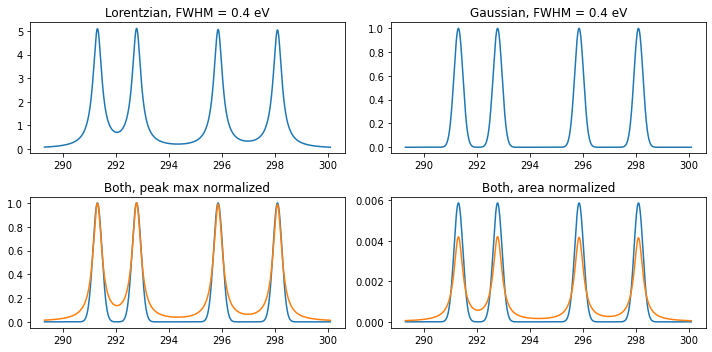

In [30]:
def lorentzian(x, y, xmin, xmax, xstep, gamma):
    '''
    Lorentzian broadening function
    
    Call: xi,yi = lorentzian(energies, intensities, start energy, end energy, energy step, gamma)
    '''
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)): yi[i] = yi[i] + y[k] * (gamma/2.) / ( (xi[i]-x[k])**2 + (gamma/2.)**2 )
    return xi,yi

def gaussian(x, y, xmin, xmax, xstep, sigma):
    '''
    Gaussian broadening function
    
    Call: xi,yi = gaussian(energies, intensities, start energy, end energy, energy step, gamma)
    '''
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)): 
        for k in range(len(y)): yi[i] = yi[i] + y[k]*np.e**(-((xi[i]-x[k])**2)/(2*sigma**2))
    return xi,yi

# IP:s from above calculation
esca_ips = [302.187, 299.362, 295.405, 293.277]

plt.figure(figsize=(10,5))
plt.subplot(221); plt.title('Lorentzian, FWHM = 0.4 eV')
x,y = esca_ips,np.ones((len(esca_ips)))
xi,yi = lorentzian(x,y,min(x)-2,max(x)+2,0.01,0.4); plt.plot(xi,yi)

plt.subplot(222); plt.title('Gaussian, FWHM = 0.4 eV')
xi,yi = gaussian(x,y,min(x)-2,max(x)+2,0.01,0.4/(2*np.sqrt(2*np.log(2)))); plt.plot(xi,yi)

plt.subplot(223); plt.title('Both, peak max normalized')
xi,yi = gaussian(x,y,min(x)-2,max(x)+2,0.01,0.4/(2*np.sqrt(2*np.log(2)))); plt.plot(xi,yi/max(yi))
xi,yi = lorentzian(x,y,min(x)-2,max(x)+2,0.01,0.4); plt.plot(xi,yi/max(yi))

plt.subplot(224); plt.title('Both, area normalized')
xi,yi = gaussian(x,y,min(x)-2,max(x)+2,0.01,0.4/(2*np.sqrt(2*np.log(2)))); plt.plot(xi,yi/sum(yi))
xi,yi = lorentzian(x,y,min(x)-2,max(x)+2,0.01,0.4); plt.plot(xi,yi/sum(yi))
plt.tight_layout(); plt.show()

For the comparison to [experiment](https://doi.org/10.1016/j.elspec.2012.05.009) a cc-pVTZ basis set is selected, augmented with additional core-polarizing functions for the carbon atoms (i.e. cc-pCVTZ):

```{figure} ../img/xray/esca_xps.svg
---
name: esca_xps
---
Carbon 1s XPS of ESCA, comparing $\Delta\textrm{SCF}$ results to experiment. Theoretical spectrum shifted by 0.11 eV (to account for relativistic effects) and broadened by 0.3 eV.
```

The features originate in, from low to high energy: -CH$_3$, -CH$_2$-, -CO-, and CF$_3$. We note a good agreement for the first two features, but the comparison deteriorates for higher energies. This is largely an effect of the more significant change in electronic structure imposed by the very electronegative fluorine and oxygen atoms, which the current level of theory is not capable of describing as well.

### Other approaches

Alternative methods of considering XPS and IP:s include, among others:

- IP-ADC

- IP-CC

- ...



(sec:xray_calc_xas)=
## X-ray absorption spectroscopy

In XAS the energy-dependent photoabsorption of the sample is measured, probing excitation of core electrons to bound or continuum states. These two different final states then provide information on unoccupied states and local chemical environment, respectively, with a prototypical spectrum of a conjugated system: 


```{figure} ../img/xray/xafs.svg
---
name: xafs
---
Prototypical X-ray absorption spectrum of a conjugated system.
```

Above the spectrum we see two disctinct regions with different features and physical origins:

- **NEXAFS (near-edge X-ray absorption fine structure:** the region in which transitions to bound states is probed (this region is also known as XANES, X-ray absorption near-edge structure).

- **EXAFS (extended X-ray absorption fine structure):** which consists of transitions to continuum states, as modulated by constructive or destructive interference between the emitted electron and the environment. This thus provide information on local chemical bonds.

Included is also the position of the IP, as well assignment of typical features ($\pi^*$, Rydberg, and $\sigma^*$). Transitions to $\pi^*$ states are typically low in energy and very intense, and thus easy to identify. Rydberg states are typically weak and converge to the ionization potential. Finally, transitions to $\sigma^*$ states can be found above the ionization potential.

The total spectrum is referred to as the **XAFS (X-ray absorption fine structure)** region. For the remainder of this tutorial we will focus on NEXAFS, for which good starting points for modeling with ADC and TDDFT can be found in {cite}`cvsadc32015, coretddft2010, xrayrev2018`.


(sec:xray_calc_cvs)=
### Decoupling from the valence continuum

A complication that arise when considering core excitations is the embedding of the core-excited states into the continuum of valence-ionized states. This means that the targetted core-excited states cannot easily be resolved with, *e.g.*, a Davidson approach, as a large number of valence-excited/-ionized states need to be converged first. A number of approaches have been developed to remove this issue, including:

- The core-valence separation (CVS) approximation {cite}`cederbaum1980, cvsadc32015, cvseomccsd2019`

- Restricted energy window (which is largely a different flavour of CVS) {cite}`rttddft2012`

- Using the complex polarization propagator (CPP), where the response at arbitrary frequencies is directly probed {cite}`cppdft1`

- Real-time propagation of the electronic structure {cite}`rttddft2012`

- Methods which construct explicit excited states

```{note}
Within a damped response framework and using real-time propagation there can be spurious mixing with valene-ionized states, which will results in unphysical mixing to a discretized continuum. This is briefly dfiscussed [here](sec:xray_cons_spur_val).
```


The focus in this tutorial is the use of the CVS approximation and the CPP approach, with which interior eigenstates and response at arbitrary frequencies can be address, as illustrated in {numref}`global_xray`:


```{figure} ../img/xray/cvs_adc.svg
---
name: global_xray
---
Global spectrum of water, using the 6-311G basis set. Results obtained with ADC(1), CVS-ADC(1), ADC(2), CVS-ADC(2), and CPP-DFT. CPP-DFT results obtained using the B3LYP exchange-correlation functional and a large $\gamma$ of 1 eV. ADC results shown as bar spectra.
```

Here we see the global spectrum of water, using a rather limited basis set. Even so, ADC(1) requires more than 50 states to resolved the core-excitation region (situated at about 535 eV for water), and for ADC(2) 50 states brings us only to about 50 eV. With the CVS approximation we directly target the core-excitation region, but it should be noted that this also introduces a small error. However, this error has been shown to be relatively small (provided a reasonable basis set) and stable for AD {cite}`Herbst2020`, and for TDHF and TDDFT it is all but negligible. Using CPP-DFT, this error is avoided all together (although CPP-ADC has been noted to be hard to converge for core-excited state {cite}`gator`, so here CVS-CPP-ADC might instead be used - thus including this small error).


### Spectra from CVS-ADC eigenstates

With CVS-ADC, the core-excitation spectra are calculate by specifying the index of the probed core orbitals(s):

In [43]:
# Construct structure and basis objects
struct  = gator.get_molecule(water_xyz)
basis   = gator.get_molecular_basis(struct,'6-31G')

# Perform SCF calculation
scf_gs  = gator.run_scf(struct,basis)

# Calculate the 6 lowest eigenstates with CVS restriction to MO #1 (oxygen 1s)
adc_res = gator.run_adc(struct,basis,scf_gs,method='cvs-adc2x',singlets=4,core_orbitals=1)

SCF converged in 5 iterations.
Total Energy: -75.9838703758 au
                                                                                                                          
                                        Algebraic Diagrammatic Construction (ADC)                                         
                                                                                                                          
                               ADC method                   : cvs-adc2x                                                   
                               Number of Singlet States     : 4                                                           
                               CVS-ADC, Core Orbital Space  : 1                                                           
                               Convergence threshold        : 1.0e-06                                                     
                                                                            

/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


  1     8        1.2621  228ms  [20.27035892 20.30081816 20.86977772 20.91121522]
  2    16      0.038976  403ms  [19.72495578 19.80691954 20.50880994 20.51569977]
  3    24     0.0035541  395ms  [19.71673636 19.7970775  20.49577427 20.50503424]
  4    32    0.00029894  438ms  [19.71639053 19.79671148 20.49373711 20.5048401 ]
  5    40     3.199e-05  451ms  [19.71637564 19.7966997  20.49353395 20.50482654]
=== Restart ===
  6    16    5.9778e-06  451ms  [19.71637513 19.79669899 20.4935131  20.5048246 ]
  7    24    1.1003e-06  474ms  [19.7163751  19.7966989  20.49350792 20.50482377]
  8    32    5.7208e-07  383ms  [19.7163751  19.7966989  20.49350748 20.50482367]
=== Converged ===
    Number of matrix applies:    64
    Total solver time:             3s 253ms
                                                                                                                          
                                                  ADC Summary of Results                                   

The resuls can be printed as a table, and convoluted and plotted using built-in functionalities or a custom broadening:

+--------------------------------------------------------------+
| cvs-adc2x                               singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      19.71638      536.5099   0.0175       0.8       0.2  |
|  1       19.7967      538.6956   0.0368    0.8087    0.1913  |
|  2      20.49351      557.6567   0.0098    0.7858    0.2142  |
|  3      20.50482      557.9647   0.1007    0.8441    0.1559  |
+--------------------------------------------------------------+



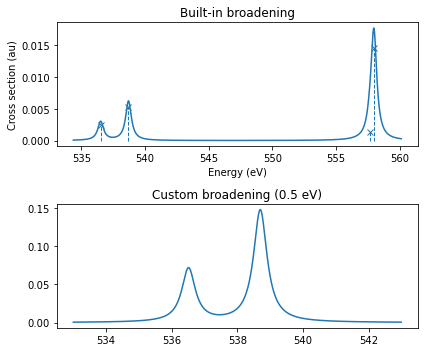

In [15]:
# Print information on eigenstates
print(adc_res.describe())

plt.figure(figsize=(6,5))
# Convolute using functionalities available in gator and adcc
plt.subplot(211); plt.title('Built-in broadening')
adc_res.plot_spectrum()

# Convoluted using information on excitation energies and oscillator strengths
plt.subplot(212); plt.title('Custom broadening (0.5 eV)')
x,y  = au2ev*adc_res.excitation_energy, adc_res.oscillator_strength
xi,yi = lorentzian(x,y,533,543,0.01,0.5); plt.plot(xi,yi)
plt.tight_layout(); plt.show()

The built-in functionality uses a small default broadening and plots the full region which is resolved, while we might want to focus on lower-energy and larger broadenings (as done in the lower panel). We note that high-energy features can often be a result of a discretized continuum region, as seen by the unphysically intense feature at $\sim$558 eV. A larger basis set will flatten out this region, but care should be taken for any analysis of that part of the spectrum.

Increasing the basis set to aug-cc-pCVTZ/cc-pVTZ (for oxygen and hydrogen, respectively), we obtain results in good agreement with [experiment](https://doi.org/10.1103/PhysRevA.47.1136):


```{figure} ../img/xray/adc_water_xas.svg
---
name: adc_water_xas
---
CVS-ADC(2)-x calculation of the oxygen X-ray absorption spectrum of gaseous water, as compared to experiment. Theoretical spectra has been shifted by 0.37 eV (to account for relativistic effects) and broadened by 0.4 eV.
```


### Spectra from TDDFT eigenstates

```{note} 
To be cleaned up.
```



We wish to model the XAS based on the CVS approximation for TDDFT. This is not available in veloxchem, and thus must be implemented.

We use that the linear response function for TDDFT (in TDHF also known as random phase approximation (RPA)), which can be written as

$$
\langle\langle \hat{\mu}_\alpha; \hat{V} \rangle\rangle_\omega =
-{\mu^{[1]}}^\dagger
\Big(
E^{[2]} - \omega S^{[2]}
\Big)^{-1}
V^{[1]}
$$

with $E^{[2]}$ being the electronic Hessian, $\omega$, being the excitation energies and $S^{[2]}$ being the overlap matrix. ${\mu^{[1]}}$ and $V^{[1]}$ are denoted the property gradients. The electronic Hessian for RPA takes the form

\begin{eqnarray}
E^{[2]} & = &
    \begin{pmatrix}
    \rule[-5pt]{0pt}{20pt}
    \rule{5pt}{0pt}
    A & B \rule{5pt}{0pt}
    \\
    \rule[-10pt]{0pt}{25pt}
    \rule{5pt}{0pt}    
    B^* & A^* \\
    \end{pmatrix}
\end{eqnarray}



\begin{eqnarray}
E^{[2]} & = &
	\begin{pmatrix}
    \rule[-5pt]{0pt}{20pt}
	\rule{5pt}{0pt}
	A & B \rule{5pt}{0pt}
	\\
    \rule[-10pt]{0pt}{25pt}
    \rule{5pt}{0pt}    
	B^* & A^* \\
	\end{pmatrix}
&	= &
    \begin{pmatrix}
    \rule[-10pt]{0pt}{30pt}
    \langle 0_i^s | \hat{H}_0 | 0_j^t \rangle - 
    \langle 0 | \hat{H}_0 | 0 \rangle \delta_{st}\delta_{ij} 
    & 
     -\langle 0_{ij}^{st} | \hat{H}_0 | 0 \rangle 
    (1 - \delta_{ij})(1-\delta_{st}) 
    \\
    \rule[-10pt]{0pt}{30pt}
    -\langle 0 | \hat{H}_0 | 0_{ij}^{st} \rangle 
    (1 - \delta_{ij})(1-\delta_{st}) 
     & 
    \langle 0_j^t | \hat{H}_0 | 0_i^s \rangle - 
    \langle 0 | \hat{H}_0 | 0 \rangle \delta_{st}\delta_{ij} 
    \\
  \end{pmatrix} 
\end{eqnarray}

* The Hessian matrix is Hermitian and has an internal structure in terms of the matrix blocks $A$ and $B$
* The diagonal elements correspond to differences in energy between the single-excited determinants $|0_i^s\rangle$ and the reference state
$|0\rangle$
* The $A$-block corresponds to the CIS approximation

In the Hartree–Fock approximation, the Hessian can be expressed as the differences in orbital energies corrected by an anti-symmetrized two-electron integral

$$
E^{[2]} = 
\begin{pmatrix}
    \rule[-10pt]{0pt}{30pt}
    F_{st} \delta_{ij} \!-\! F_{ji}\delta_{st} \!-\! \langle sj || ti
    \rangle 
    & 
    -\langle st||ij \rangle 
    \\
    \rule[-10pt]{0pt}{30pt}
    -\langle ij||st \rangle 
    & 
    F_{ts} \delta_{ij}\! -\! F_{ij} \delta_{st} 
    \! - \! \langle ti || sj \rangle 
    \\
\end{pmatrix}
$$

* The anti-symmetrized ERI gives the correct asymptotic behavior for charge-transfer excitations
* At the level of DFT, the exchange–correlation functional is introduced and the asymptotic behavior becomes incorrect

We observe that this matrix can be written in terms of $A$ and $B$ blocks. The diagonal blocks correspond to energy differences between single-excited state determinants and the reference state, while the $B$ blocks consists of energies of double excited states. A commonly used approximation known as the Tamm-Dancoff approximation (TDA) consists in neglecting the $B$-blocks.

In the RPA the overlap matrix is trivially 

\begin{eqnarray}
\label{S2}
S^{[2]} & = &
    \begin{pmatrix}
    \rule[-5pt]{0pt}{20pt}
    \rule{5pt}{0pt}
    1 & 0 \rule{5pt}{0pt}
    \\
    \rule[-10pt]{0pt}{25pt}
    \rule{5pt}{0pt}    
    0 & -1 \\
    \end{pmatrix} ,
\end{eqnarray}

The property gradients also take the simple form

\begin{equation}
  V^{[1]} =
    \begin{pmatrix}
    \rule[-5pt]{0pt}{15pt}
    g
    \\
    \rule[-5pt]{0pt}{0pt}
    -g^*
\\
  \end{pmatrix}
\end{equation}

In the SCF approximation, the property gradient takes the form

\begin{equation}
  V^{[1]} =
  \begin{pmatrix}
    \rule[-10pt]{0pt}{20pt}
     \langle 0 | [\hat{a}_{i}^\dagger\hat{a}_{s}, \hat{V}] | 0 \rangle
       \\
    \rule[-5pt]{0pt}{20pt}
     \langle 0 | [\hat{a}_{s}^\dagger\hat{a}_{i}, \hat{V}] | 0 \rangle
\\
  \end{pmatrix} 
  =
  \begin{pmatrix}
    \rule[-5pt]{0pt}{15pt}
     \langle 0_i^s | \hat{V} | 0 \rangle
       \\
    \rule[-5pt]{0pt}{0pt}
     -\langle 0 | \hat{V} | 0_i^s \rangle
    \\
  \end{pmatrix}
  =
      \begin{pmatrix}
    \rule[-5pt]{0pt}{15pt}
    g
       \\
    \rule[-5pt]{0pt}{0pt}
     -g^*
\\
  \end{pmatrix}
\end{equation}

Observe that the upper part of the vector corresponds to excitation, while the lower part corresponds to deexcitation. Likewise, for the matrices the upper left block corresponds to excitation, while the lower right part corresponds to deexcitation. The off-diagonal blocks corresponds to mixed excitation/deexcitation.

The excitation energies can be determined as the poles of the polarization propagator, i.e. $
\Big(E^{[2]} - \omega S^{[2]}\Big) = 0$, and thus to obtain these, we solve the eigenvalue problem

$$
E^{[2]}X = {\lambda} S^{[2]}X 
$$

where

$$
{\lambda} =\begin{pmatrix}
\lambda & 0\\
0 & -\lambda
\end{pmatrix}
$$

It is possible to choose the eigenvectors $X_n$ of which $X$ consists, so that

$$
X^{\dagger}E^{[2]}X = {\lambda} I \textrm{   and   } X^{\dagger}S^{[2]}X = I
$$

with 
$$
I = \begin{pmatrix}
1 &0\\
0&-1
\end{pmatrix}
$$

We can thus write

\begin{align}
\langle\langle \hat{\mu}_\alpha; \hat{V} \rangle\rangle_\omega &=
-{\mu^{[1]}}^\dagger
\Big(
E^{[2]} - \omega S^{[2]}
\Big)^{-1}
V^{[1]}
\\
&=
-{\mu^{[1]}}^\dagger
XX^{-1}\Big(
E^{[2]} - \omega S^{[2]}
\Big)^{-1}(X^{\dagger})^{-1}X^{\dagger}
V^{[1]}\\
&=
-{\mu^{[1]}}^\dagger
X\Big( X^{\dagger} \Big(
E^{[2]} - \omega S^{[2]}
\Big)X\Big)^{-1}X^{\dagger}
V^{[1]}\\
&=
-{\mu^{[1]}}^\dagger
X\Big( \lambda I - \omega I\Big)^{-1}X^{\dagger}
V^{[1]}
\\
&=
-\sum_n \dfrac{{\mu^{[1]}}^\dagger X_n X_n^{\dagger}V^{[1]}}{\lambda_n -\omega_n} +\dfrac{{\mu^{[1]}}^{\dagger} X_n X_n^{\dagger}V^{[1]}}{\lambda_n +\omega_n}
\end{align}

The above corresponds to the well known sum over states expression for the polarization propagator and hence we can identify the transition moment as $X_n^{\dagger}V_{\beta}^{[1]}$. Thus we can obtain the oscillator strength as:

$$
(T^{\mu})^{2} = \sum_{\beta=x,y,z}{\mu_{\beta}^{[1]}}^\dagger X_n X_n^{\dagger}\mu_{\beta}^{[1]}\\
f_{osc}^{if} = \frac{2}{3}\cdot \omega_{if}\cdot(T^{\mu})^2
$$


### Transition moments
Since $(\Omega \Lambda)^{-1} = \Lambda^{-1} \Omega^{-1}$, we can form the inverse of the RPA matrix as

\begin{equation}
  \left( E^{[2]} - \omega S^{[2]} \right)^{-1} =
  X \left[ X^\dagger \left( E^{[2]} - \omega S^{[2]} \right) X \right]^{-1} X^\dagger
\end{equation}

which yields an expression for the linear response function that reads

\begin{eqnarray}
\label{lrf-resolved}
  \langle
  \langle
  \hat{\Omega}; \hat{V}
  \rangle
  \rangle & = &
  -
  \left[\Omega^{[1]}\right]^\dagger 
  \sum_{e=1}^n
  \left(
  \frac{
    X_e
    X^\dagger_e
    }{
    \lambda_e - \hbar \omega
    }
  +
  \frac{
    X_e
    X^\dagger_e 
    }{
    \lambda_e + \hbar \omega
    }
  \right) V^{[1]} 
\end{eqnarray}

This equation suggests that we identify the $\lambda$-eigenvalues as excitation energies of the system and transition moments in the SCF approximation are identified as

\begin{equation}
\label{tranmom}
    \langle f | \hat{V} | 0 \rangle =
    X^\dagger_f V^{[1]}
\end{equation}

In [18]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_str(water_xyz, units='angstrom')
basis    = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF settings and calculation
scf_drv         = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings    = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'b3lyp'}
scf_drv.update_settings(scf_settings,method_settings)
scf_drv.compute(molecule, basis)

# Set MO dimension variables 
nocc = 5 # number of occupied MOs
nvirt = 8 # number of virtual MOs
n = nocc * nvirt # number of single excitations

# Set CVS variables
ncore = 1 # number of cores to consider
c = ncore * nvirt # number of core excitations
c_int = 0 # index for first core of interest (for water O is lowest MO, hence index 0)

In [20]:
# Initialize linear response solvers
lrs = vlx.LinearResponseEigenSolver(comm,silent_ostream)
lrs.update_settings(scf_settings, method_settings)
rsp_drv = vlx.LinearResponseSolver(comm,silent_ostream)
rsp_drv.update_settings(scf_settings, method_settings)
# Get full electronic Hessian
E2  = lrs.get_e2(molecule, basis, scf_drv.scf_tensors)

# Get property gradients for dipole operator
V1_x = rsp_drv.get_prop_grad('electric dipole', 'x', molecule, basis, scf_drv.scf_tensors)[0]
V1_y = rsp_drv.get_prop_grad('electric dipole', 'y', molecule, basis, scf_drv.scf_tensors)[0]
V1_z = rsp_drv.get_prop_grad('electric dipole', 'z', molecule, basis, scf_drv.scf_tensors)[0]

AttributeError: 'LinearResponseEigenSolver' object has no attribute 'get_e2'

In [ ]:
# Define starting index for deexcitation part for relevant core
c_int_deex = n + c_int
# Set up CVS Hessian
E2_CVS = np.zeros((2 * c, 2 * c))
# Get Hessian elements related to relevant core excitations
E2_CVS[0:c, 0:c] = E2[c_int:c, c_int:c]
E2_CVS[0:c, c:2*c] = E2[c_int:c, c_int_deex:c_int_deex+c]
E2_CVS[c:2*c, 0:c] = E2[c_int_deex:c_int_deex+c, c_int:c]
E2_CVS[c:2*c, c:2*c] = E2[c_int_deex:c_int_deex+c, c_int_deex:c_int_deex+c]

# Set up CVS overlap matrix
S2_CVS =  np.identity(2*c)
S2_CVS[c:2*c,c:2*c] *= -1


#Set up CVS property gradients
V1_CVS_x = np.zeros(2*c)
V1_CVS_x[0:c] = V1_x[c_int:c]; V1_CVS_x[c:2*c] = V1_x[c_int_deex:c_int_deex+c]
V1_CVS_y = np.zeros(2*c)
V1_CVS_y[0:c] = V1_y[c_int:c]; V1_CVS_y[c:2*c] = V1_y[c_int_deex:c_int_deex+c]
V1_CVS_z = np.zeros(2*c)
V1_CVS_z[0:c] = V1_z[c_int:c]; V1_CVS_z[c:2*c] = V1_z[c_int_deex:c_int_deex+c]

# Solve CVS eigenvalue problem
Sinv = np.linalg.inv(S2_CVS)
M = np.matmul(Sinv, E2_CVS)
eigs_CVS, X_CVS = np.linalg.eig(M)

# Resort eigenvalue and vector arrays from largest to lowest eigenvalue
idx   = np.argsort(eigs_CVS)
eigs_CVS = np.array(eigs_CVS)[idx]
X_CVS = np.array(X_CVS)[:,idx]

# Compute oscillator strength and print 
fosc_array = np.zeros(int(len(eigs_CVS)/2))
print(f'Excitation Energy/eV     Osc. strength')
print(f'-------------------------------------------')
for i in range(int(len(eigs_CVS)/2)):
    j = i + int(len(eigs_CVS)/2)
    Xf_CVS = X_CVS[:,j]
    Xf_CVS =  Xf_CVS / np.sqrt(np.matmul(Xf_CVS.T, np.matmul(S2_CVS, Xf_CVS)))
    strength_CVS = np.dot(Xf_CVS, V1_CVS_x)**2+np.dot(Xf_CVS, V1_CVS_y)**2+np.dot(Xf_CVS, V1_CVS_z)**2
    fosc = strength_CVS*2.0/3.0*eigs_CVS[j]
    print(f'   {eigs_CVS[j]*au2ev : .2f}                   {fosc : .6f}')
    fosc_array[i] = fosc
print(f'-------------------------------------------')

# Plot with Lorentzian broadening
plt.figure(figsize=(6,5))
plt.subplot(211); plt.title('CVS TDDFT XAS')
x,y = eigs_CVS[int(len(eigs_CVS)/2):], fosc_array
xi,yi = lorentzian(x,y,515/au2ev, 525/au2ev,0.001,0.3/au2ev); plt.plot(xi*au2ev,yi)

plt.tight_layout(); plt.show()

In [1]:
# should be the same, of cource...
print(Sinv)
print(S2_CVS)
# not the use of eig, not eigh - not fully Hermitian (B-block)

NameError: name 'Sinv' is not defined

- Compare to functions in veloxchem
- Can also consider TDA (and compare)

### Spectra from CPP-DFT

With the complex polarization propagator (CPP), also called the damped linear response function, the absorption and dispersion spectrum can be evaluated at arbitrary energies {cite}`cpp1`. With this, the X-ray absorption spectrum can then be directly calculated. For this, we need to decide on which energy/frequency region to use, which can be estimated by, *e.g.*

- Screen extended energy regions with large step size. This could potentially be done using a smaller basis set.

- With a method lacking relaxation: start the region a few eV below the IP from Koopmans' theorem. This will not work for methods capable of including relaxation, where IP:s from $\Delta$SCF could instead be considered as a first rough estimate (noting that it will work better or worse for different levels of, e.g., ADC theory).

Choosing an energy region of 514-525 eV, using a step length of 0.1 eV and a damping factor of 0.3 eV, we calculate the CPP-DFT (with the B3LYP functional) water spectrum as:

```python
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_str(water_xyz)
basis    = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF settings and calculation
scf_drv         = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings    = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'b3lyp'}
scf_drv.update_settings(scf_settings,method_settings)
scf_drv.compute(molecule, basis)

# Define spectrum region to be resolved
freqs = np.arange(515.0,525.0,0.1)/au2ev
freqs_str = [str(x) for x in freqs]

# Calculate the response
cpp_prop = LinearAbsorptionCrossSection({'frequencies': ','.join(freqs_str), 'damping': 0.3/au2ev},method_settings)
cpp_prop.init_driver(comm, ostream=silent_ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)

# Extract the imaginary part of the complex response function and convert to absorption cross section
sigma = []
for w in freqs:
    axx = - cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = - cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = - cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0
    sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)
```

Resulting spectra can be plotted as raw, or splined for smoother figures:


```python
# Make figure with panels of 3:1 width
plt.figure(figsize=(9,5))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1]) 

# Raw results for the full region
plt.subplot(gs[0])
plt.plot(au2ev*freqs,sigma,'bx-')

# Raw results for a zoomed in region
plt.subplot(gs[1])
plt.plot(au2ev*freqs,sigma,'bx-')
plt.xlim((519.5,520.5)); plt.ylim((0,0.10))

# Raw and splined spectra for the full region
plt.subplot(gs[2])
plt.plot(au2ev*freqs,sigma,'bx')
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
y = interp1d(au2ev*freqs, sigma, kind='cubic')
plt.plot(x,y(x),'r')
plt.legend(('Raw','Splined'))

# Zoomed in raw and splined spectra for the full region
plt.subplot(gs[3])
plt.plot(au2ev*freqs,sigma,'bx')
plt.plot(x,y(x),'r')
plt.xlim((519.5,520.5)); plt.ylim((0,0.10))
plt.show()
```


```{figure} ../img/xray/cpp_dft.svg
---
name: xray_cpp_dft
---
```

Increasing the basis set size and comparing to [experiment] we get:


```{figure} ../img/xray/dft_water_xas.svg
---
name: dft_water_xas
---
CPP-DFT (B3LYP) X-ray absorption spectrum of water, as compared to experiment. Theoretical spectra shifted by 14.5 eV and broadened by 0.4 eV.
```

```{note} 
Change above results to aug-cc-pCVTZ/cc-pVTZ.
```

As can be seen, the absolute excitation energies are significantly of, with a shift of 14.5 eV required to yield an approximate alignment to experiment. Part of this shift is due to lack of relativistic effects (~0.37 eV), and a small discrepancy can be expected due to the use of a limited basis set, but the main part of the error is due to two different effects:

1. Lack of [relaxation](sec:xray_topics_relax), which yield a final state too high in energy and thus shift theoretical spectra upwards in energy.

2. The [self-interaction error](sec:xray_topics_sie), which yield an erroneous self-repulsion of the dense core orbitals, and results in too low core-excitation energies.

For B3LYP the final effect of these two errors results in too low transition energies, meaning that the SIE dominates. By changing the amount of HF exchange this balance will shift and the error eventually becomes positive.

Nevertheless, the obtained CPP-DFT spectrum is in reasonable agreement with experiment once it has been shifted.


### Other approaches

Alternative methods of considering XAS include, among others:

- STEX

- TP-DFT

- RAS

- NOCIS

- ...

(sec:xray_calc_xes)=
## X-ray emission spectroscopy

Following the creating of a core-hole, the system will rapidly ($\sim$fs) decay to a valence-hole or valence-excited state, depending on whether the system is core-ionized or core-excited. These two different intermediate states  are probed when the X-ray pulse is in resonance (excited regime) or not (ionized regime), yieldig resonant/non-resonant X-ray emission spectroscopy. This section will focus on the latter, with the former following in the next section.

In the decay process the system gain large amounts of energy which need to be discarded, as can occur by emission of high-energy photon (fluorescence) or high-lying electron (Auger), with relative probability depending on edge and element. For the *K*-edge the relative probabilities are:

```{figure} ../img/xray/auger_vs_fluorescent.png
---
name: auger_vs_fluorescent
---
Fluorescence and Auger electron yields as a function of atomic number for *K*-edge core-holes. Figure taken from wikipedia.org, as [published](https://commons.wikimedia.org/wiki/File:Auger_xray_wiki_in_png_format.png) under CC BY-SA 4.0.
```

Auger decay thus dominates for light elements, which has impact on both our ability of obtaining well-resolved spectra for these elements, as well as the impact of X-ray damage on biological matter.

In non-resonant XES we measure the fluorescent decay of core-ionized states, through which we probe the (element-specific) nature of the local chemical environment. For light elements the valence space is probed directly, but for heavier elements we obtain a number of different decay channels from the valence region and the outer core region. These lines vary considerably in energy, intensity, and information content {cite}`guideXray2016`:

1. The $2p \rightarrow 1s$ ($K\alpha_1$ and $K\alpha_2$) is the most intense (due to the large overlap) and of lowest energy, and is relatively insensitive to the valence region

2. The $3p \rightarrow 1s$ ($K\beta ' $ and $K\beta_{1,3}$) is about an order of magnitude weaker and of higher energy, but more sensitive to the environment

3. Transitions from the ligand MO:s ($K\beta '' $ and $K\beta_{2,5}$), or valence-to-core (VtC), is the weakest, high-energy features which is most sensitive to the local environment


This tutorial focus on spectra of light elements, as modelled by (TD)DFT and ADC. A good starting point for learning about such modeling can be found in {cite}`coretddft2010, adcxes2019, dftXray2021`.



### Spectra from ADC

One approach for considering X-ray emission spectra is to converge the core-hole state and use this core-ionized system as the reference state for a normal excited state calculation {cite}`coretddft2010, adcxes2019`. The core-decay transitions are then the first negative eigenstates of the system, such that a standard Davidson calculation can be run on top.

Considering water with ADC(2), the oxygen X-ray emission spectrum is calculated as:

In [19]:
# Create pyscf mol object
mol       = gto.Mole()
mol.atom  = water_xyz
mol.basis = '6-31G'
mol.build()

# Perform unrestricted SCF calculation
scf_res = scf.UHF(mol)
scf_res.kernel()

# Copy molecular orbitals
mo0        = copy.deepcopy(scf_res.mo_coeff)
occ0       = copy.deepcopy(scf_res.mo_occ)

# Create 1s core-hole by setting alpha_0 population to zero
occ0[0][0] = 0.0

# Perform unrestricted SCF calculation with MOM constraint
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# Perform ADC calculation of first four states
adc_xes = adcc.adc2(scf_ion, n_states = 4)

converged SCF energy = -75.9838703827192  <S^2> = 6.337153e-12  2S+1 = 1
converged SCF energy = -56.0754789470864  <S^2> = 0.76257805  2S+1 = 2.0125387


/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8       0.77768   1.3s  [-19.29082067 -19.19940205 -18.96181907 -18.3637012 ]
  2    16     0.0010764  153ms  [-19.44427093 -19.36689642 -19.16826546 -18.57947501]
  3    24    4.4301e-07  312ms  [-19.44429764 -19.3669284  -19.16831914 -18.57954987]
=== Converged ===
    Number of matrix applies:    24
    Total solver time:             1s 806ms


```{note}
There will be convergence issues if including transitions from very different types, *e.g.* resolving transitions into the core and out to the unoccupied valence region simultaneously. As such, the number of resolved states should remain limited to the number of potential decay channels.
```

The resuls can be printed as a table, and convoluted and plotted using built-in functionalities or a custom broadening. Note that the eigenvalues are negative, and a sign change is thus appropriate when constructing the spectra.

+--------------------------------------------------------------+
| adc2                                        any ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      -19.4443     -529.1063   0.0568    0.9548    0.0452  |
|  1     -19.36693      -527.001   0.0458    0.9503   0.04966  |
|  2     -19.16832     -521.5965   0.0419    0.9376   0.06245  |
|  3     -18.57955     -505.5753   0.0031    0.9335   0.06655  |
+--------------------------------------------------------------+



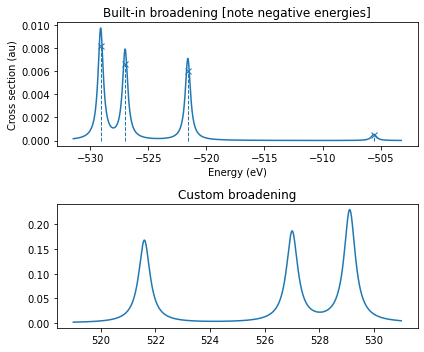

In [20]:
# Print information on eigenstates
print(adc_xes.describe())

plt.figure(figsize=(6,5))
# Convolute using functionalities available in gator and adcc
plt.subplot(211); plt.title('Built-in broadening [note negative energies]')
adc_xes.plot_spectrum()

# Convoluted using information on excitation energies and oscillator strengths
plt.subplot(212); plt.title('Custom broadening')
x,y = -au2ev*adc_xes.excitation_energy, adc_xes.oscillator_strength
xi,yi = lorentzian(x,y,519,531,0.01,0.5); plt.plot(xi,yi)
plt.tight_layout(); plt.show()

Using cc-pCVTZ/cc-pVTZ and comparing to experiment {cite}`gaswaterrixs2012`:

```{figure} ../img/xray/adc_water_xes.svg
---
name: adc_water_xes
---
ADC(2) water X-ray emission spectrum, as compared to experiment. Theoretical spectra shifted by 0.37 eV (to account for relativistic effects) and broadened by 0.3 eV.
```

While the broadening between the different lines is noticably different, it is clear that the energy spacing and integrated intensities of the features are in good agreement with experiment. Note that the theoretical spectrum is obtained at the ADC(2) level of theory, which has been to be in better agreement than ADC(2)-x and ADC(3/2) for XES {cite}`adcxes2019`.


### Spectra from TDDFT

```{note}
To be added.
```

### Spectra from ground state MO:s

While we have previously seen that Koopmans' theorem is in significant disagreement with experimental ionization potentials (due to lack of relaxation), it has been noted that the *relative* position of the (valence) MO energies can still be quite reasonable. As such, a computationally very simple approach for modeling X-ray emission spectra has been used, in which transition energies are estimated from

\begin{equation}
\Delta E = \epsilon_v - \epsilon_c
\end{equation}

*i.e.* the difference in ground state MO energies. The intensities are taken to be proportional to the dipole moment:

\begin{equation}
f \propto \left| \langle \phi_i \left| \hat{\mu} \right| \phi_c \rangle \right| ^2
\end{equation}

This method is very attractive in its simplicity, requiring only a single ground state calculation and the construction of some transition dipole moments for a full spectrum calculation. However, the absolute energies are significantly off, and any differences in relaxation between the different channels will not be included.

Nevertheless, this approach has been noted to yield good (relative) agreement to experimental measurements {cite}`dftXray2021`, and it is capable of considering even massive molecular systems.

The calculation of an emission spectra requires the calculation of the ground state wave function and all relevant transition dipole moments:

In [21]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_str(water_xyz)
basis    = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF settings and calculation
scf_drv          = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings     = {'conv_thresh': 1.0e-6}
method_settings  = {'xcfun': 'b3lyp'}
scf_drv.update_settings(scf_settings,method_settings)
scf_drv.compute(molecule, basis)

# Extract orbital energies and number of occupied MOs
orbital_energies = scf_drv.scf_tensors['E']
nocc = molecule.number_of_alpha_electrons()
print('Occupied MO energies:',au2ev*orbital_energies[:nocc])

# Define probed core MO and calculate energy differences
n_core = 0
energy_diff = []
for n_mo in np.arange(nocc):
    if n_mo != n_core:
        energy_diff.append(au2ev*(orbital_energies[n_mo]-orbital_energies[n_core]))

# Extract MO coefficients
mo_C = scf_drv.scf_tensors['C']
         
# Load drivers for transition dipole moment
dipole_drv = vlx.ElectricDipoleIntegralsDriver(comm)

# Calculated transition dipole moments and convert to MO basis
dipole_matrices = dipole_drv.compute(molecule, basis)
x_ao = dipole_matrices.x_to_numpy(); x_mo = np.matmul(mo_C.T, np.matmul(x_ao, mo_C))
y_ao = dipole_matrices.y_to_numpy(); y_mo = np.matmul(mo_C.T, np.matmul(y_ao, mo_C))
z_ao = dipole_matrices.z_to_numpy(); z_mo = np.matmul(mo_C.T, np.matmul(z_ao, mo_C))

# Construct oscillator strengths
xx,yy,zz,sigma = [],[],[],[]
for n_mo in np.arange(nocc):
    if n_mo != n_core:
        x_tmp,y_tmp,z_tmp = x_mo[n_core,n_mo],y_mo[n_core,n_mo],z_mo[n_core,n_mo]
        xx.append(x_tmp); yy.append(y_tmp); zz.append(z_tmp)
        sigma.append(x_tmp**2+y_tmp**2+z_tmp**2)

Occupied MO energies: [-520.65709504  -27.68789281  -14.39952883   -9.70377533   -7.94952959]


The resuls can be printed as a table, and convoluted and plotted using a custom broadening. We here focus on the high-energy for the latter:

Energy   Osc. str.   x-component   y-component   z-component
492.969   0.00022      0.00000      -0.00000      -0.01478
506.258   0.00238      0.04878      -0.00000       0.00000
510.953   0.00255     -0.00000      -0.00000       0.05050
512.708   0.00342      0.00000       0.05848       0.00000


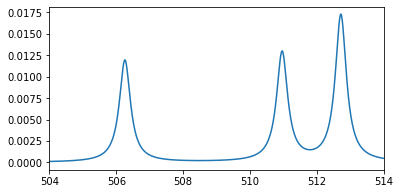

In [22]:
# Print results as a table
print('Energy   Osc. str.   x-component   y-component   z-component')
for i in np.arange(len(energy_diff)):
    e,os,x,y,z = energy_diff[i],sigma[i],xx[i],yy[i],zz[i]
    print('{:.3f}  {:8.5f}     {:8.5f}      {:8.5f}      {:8.5f}'.format(e,os,x,y,z))

# Plot X-ray emission spectrum
plt.figure(figsize=(6,3))
x,y   = energy_diff,sigma
xi,yi = lorentzian(x,y,min(x)-5,max(x)+5,0.01,0.4)
plt.plot(xi,yi)
plt.xlim((504,514))
plt.show()

Using a cc-pCVTZ/cc-pVTZ basis set and comparing to experiment {cite}`gaswaterrixs2012`:


```{figure} ../img/xray/overlap_water_xes.svg
---
name: /overlap_water_xes
---
DFT (B3LYP) overlap X-ray emission spectrum of water, as compared to experiment. Theoretical spectra shifted to approximately align the high-energy feature, and broadened by 0.3 eV.
```

The resulting spectrum is very much off in energy, but the relative agreement to experiment is quite impressive.


### Other approaches

Alternative methods of considering XES include, among others:

- CC

- ...

(sec:xray_calc_rixs)=
## Resonant inelastic X-ray scattering

We here focus on the electronic part of the RIXS plane. Can also go close to the Rayleigh line, which probe local vibrational modes.


### Two-step approach with ADC

An approximate treatment of the RIXS plane can be achieved by considering it as a two-step process {cite}`adcwaterrixs2018`, with:

1. A core-excitation as modeled like a normal X-ray absorption spectrum

2. A core-decay process from the core-hole system with an electron put in each relevant final state probed in (1), modeled as a (non-resonant) X-ray emission spectrum

{\bf Note and discuss:} Spin-contamination, with <S^2> = 1

The RIXS plane is then constructed from above absorption and emission energies, with RIXS intensity from the multiplication of respective oscillator strength.

Note that this approach is an approximation, as it disregards potentially important detuning effects, and in the example given below we also ignore existing coupling between the polarization in the incoming and outgoing photon. Furthermore, it requires the convergence of core-ionized states, which is much trickier than core-ionized, and will likely only work for the first few core-excited states.

Nevertheless, the scheme is quite easy to understand, and introducing core-excited dynamics is relatively straightforward. As such, we here illustrate how the RIXS plane of water can be constructed.

```python
# Create pyscf mol object
mol       = gto.Mole()
mol.atom  = water_xyz
mol.basis = '6-31G'
mol.build()

# Perform restricted SCF calculation
scf_gs = scf.RHF(mol)
scf_gs.kernel()

# Calculate X-ray absorption spectrum
adc_xas = adcc.cvs_adc2(scf_gs, n_singlets=4, core_orbitals=1)
print(adc_xas.describe())

# Perform unrestricted SCF calculation
scf_gs = scf.UHF(mol)
scf_gs.kernel()

# Calculate resonant X-ray emission spectrum
#   for states where the core-electron is moved to LUMO or LUMO+1
adc_rxes = []
for n in [5,6]:
    # Copy molecular orbitals
    mo0  = copy.deepcopy(scf_gs.mo_coeff)
    occ0 = copy.deepcopy(scf_gs.mo_occ)
    # Move 1s electron to LUMO / LUMO+1
    occ0[0][0] = 0.0
    occ0[0][n] = 1.0
    # Perform unrestricted SCF calculation with MOM constraint
    scf_ion = scf.UHF(mol)
    scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    # Calculate resonant X-ray emission spectrum
    adc_rxes.append(adcc.adc2(scf_ion, n_states=4))
```

Now the correct combinations of transition energies and intensities need to be constructed:

```python
adc_rixs = []

# Probing LUMO and LUMO+1
for indx in [0,1]:
    # From XAS calculation
    E_xas = au2ev*adc_xas.excitation_energy[indx]
    I_xas = adc_xas.oscillator_strength[indx]
    # From XES calculation
    for i in np.arange(len(adc_rxes[indx])):
        E_xes = -au2ev*adc_rxes[indx].excitation_energy[i]
        I_xes = adc_rxes[indx].oscillator_strength[i]
        adc_rixs.append([E_xas, E_xes, I_xas*I_xes])
```

And the RIXS plane can then be constructed:

```python
plt.figure(figsize=(8,6))
# Plot absorption spectrum
plt.subplot(222)
x,y   = au2ev*adc_xas.excitation_energy, adc_xas.oscillator_strength
xi,yi = lorentzian(x,y,min(x)-2,min(x)+5,0.01,0.3)
plt.plot(yi,xi)

# Plot emission specta, with vertical shift from absorbed energy
plt.subplot(223)
# LUMO
x,y   = -au2ev*adc_rxes[0].excitation_energy, adc_rxes[0].oscillator_strength
xi,yi = lorentzian(x,5.*y,x[1]-9,x[1]+2,0.01,0.3)
plt.plot(xi,yi+au2ev*adc_xas.excitation_energy[0])
# LUMO+1
x,y   = -au2ev*adc_rxes[0].excitation_energy, adc_rxes[1].oscillator_strength
xi,yi = lorentzian(x,5.*y,x[1]-9,x[1]+2,0.01,0.3)
plt.plot(xi,yi+au2ev*adc_xas.excitation_energy[1])

# Plot RIXS plane, here with marker size scaling with intensity
plt.subplot(221)
for i in np.arange(len(adc_rixs)):
    tmp = adc_rixs[i]
    plt.plot(tmp[1],tmp[0],'ok',markersize=10000*tmp[2])
    
# Zooming in to region spanned by XAS and XES projections
plt.xlim((519,530))
plt.ylim((536,544))
    
plt.tight_layout(); plt.show()
```


```{figure} ../img/xray/adc_2st_rixs.svg
---
name: adc_2st_rixs
---
```

### Two-step approach with TDDFT

```{note}
To be added.
```


### Dirac-Kramer-Heisenberg with ADC

```{note}
To be added.
```

### HERFD

```{note}
Discuss briefly - could add illustration.
```


### Other approaches

Alternative methods of considering RIXS include, among others:

- ...